In [7]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score, v_measure_score # и другие метрики
from sklearn.cluster import KMeans, AgglomerativeClustering # а также другие алгоритмы

In [8]:
DATA_PATH = "../data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 1000
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [9]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [10]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

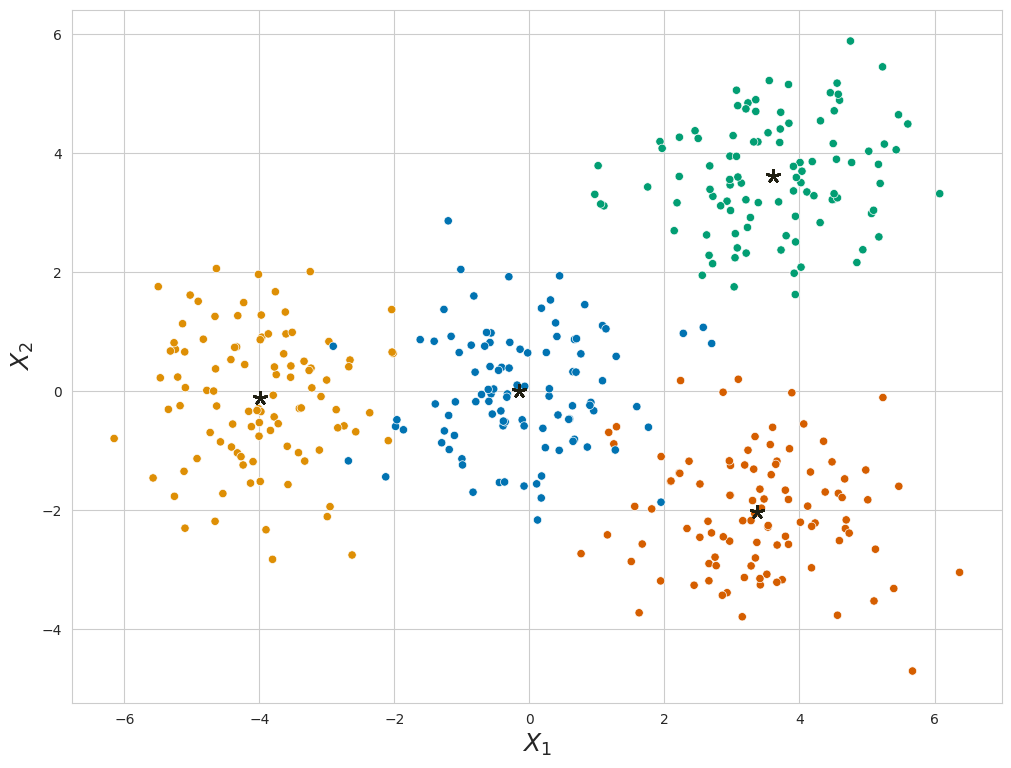

In [11]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [14]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize

    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        
        dists = []
        for centroid in self.centroids:
            dists.append([self._calculate_distance(X, centroid)])
        dists = np.concatenate(dists, axis=1)
        cluster_labels = np.argmin(dists, axis=1)
            
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        
        return np.linalg.norm(centroid - X, axis=1).reshape(-1,1)
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

В данном случае разные способы отбора начальных позиций центроидов не играют сильной разницы оба находят центры кластеров быстро.

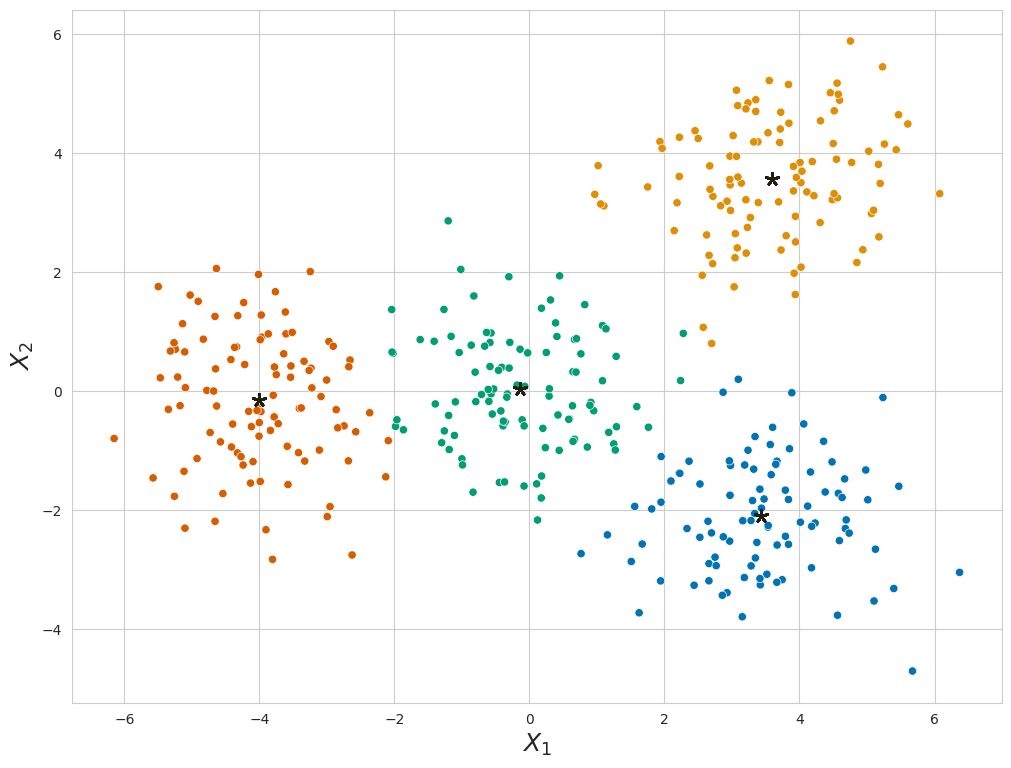

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [15]:
model = MyKMeans(4, 'random', 400, True)
model.fit(X)

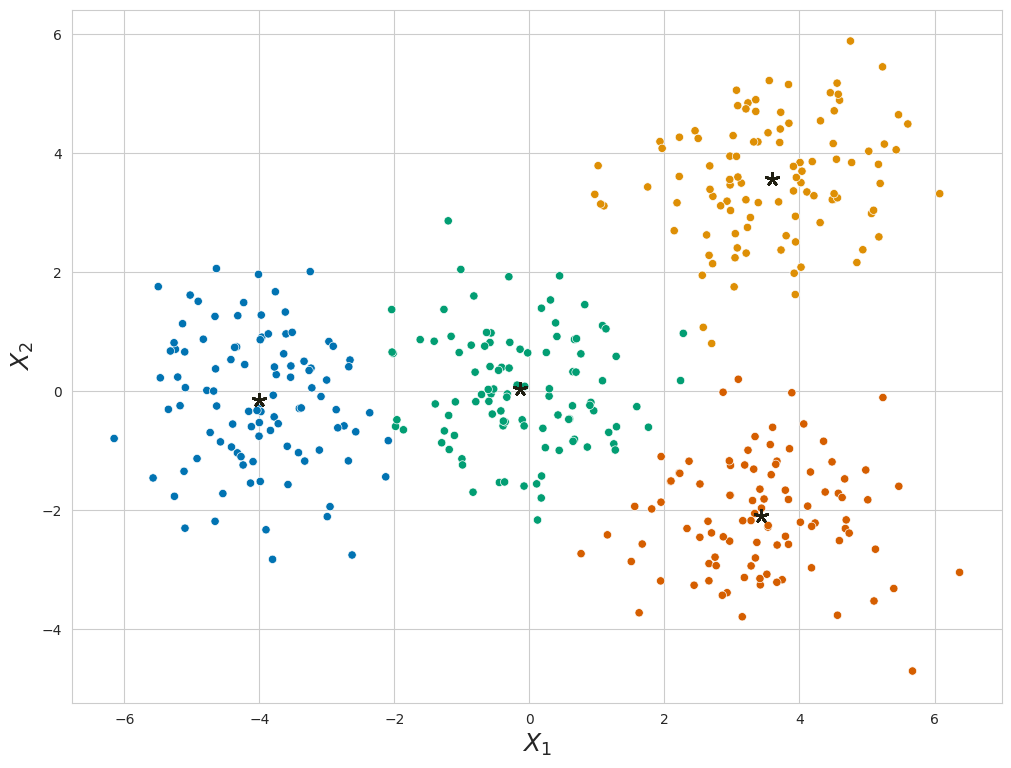

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [16]:
model = MyKMeans(4, 'sample', 400, True)
model.fit(X)

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [17]:
data = load_digits()
X, y = data.data, data.target
np.unique(y) # 10 групп

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

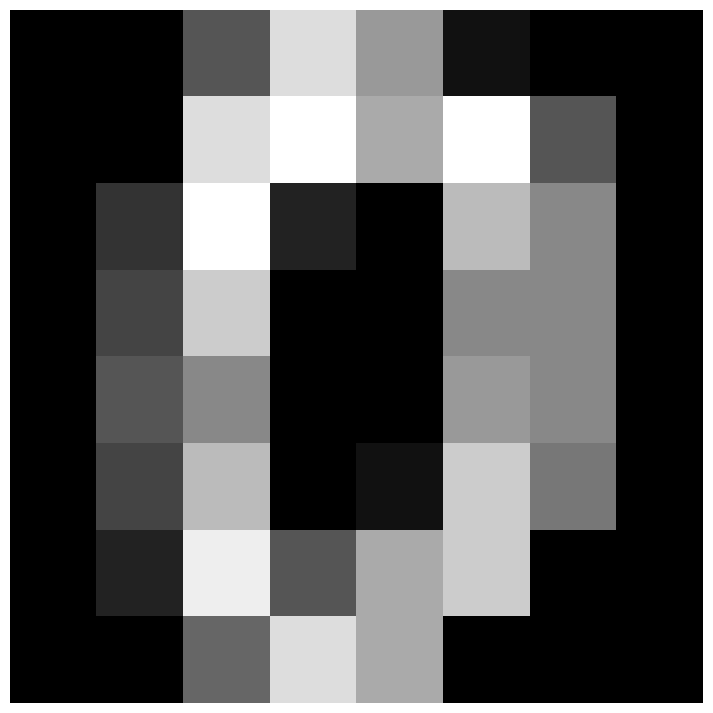

In [18]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`).

##### YOUR TURN TO CODE

In [19]:
def algorithm_selection(X, y=None, clusters=None, distances=['euclidean', 'manhattan', 'minkowski', 'cosine'], algorithms=['average', 'single', 'complete']):
    results = []
    
    for distance in distances:
        for algorithm in algorithms:
                cluster = AgglomerativeClustering(n_clusters=clusters, linkage=algorithm, metric=distance)
                cluster_labels = cluster.fit_predict(X)
                
                homogeneity = None if y is None else homogeneity_score(y, cluster_labels)
                completeness = None if y is None else   completeness_score(y, cluster_labels)
                v_measure = None if y is None else v_measure_score(y, cluster_labels)
                silhouette = silhouette_score(X, cluster_labels)

                results.append([distance, algorithm, homogeneity, completeness, v_measure, silhouette])
    
    columns = ['distance', 'algorithm', 'homogeneity', 'completeness', 'v_measure', 'silhouette']
    compare_dataframe = pd.DataFrame(results, columns=columns)
    
    return compare_dataframe

In [20]:
algorithm_selection(X, y, 10).sort_values('silhouette', ascending=False)

distance algorithm  homogeneity  completeness  v_measure  silhouette
0   euclidean   average     0.655393      0.782342   0.713263    0.146625
6   minkowski   average     0.655393      0.782342   0.713263    0.146625
5   manhattan  complete     0.646372      0.686109   0.665648    0.140183
9      cosine   average     0.648268      0.808762   0.719676    0.129526
2   euclidean  complete     0.590549      0.637772   0.613253    0.119271
8   minkowski  complete     0.590549      0.637772   0.613253    0.119271
3   manhattan   average     0.566751      0.778942   0.656117    0.089217
11     cosine  complete     0.528727      0.577415   0.551999    0.088021
1   euclidean    single     0.005056      0.273755   0.009929   -0.133621
7   minkowski    single     0.005056      0.273755   0.009929   -0.133621
10     cosine    single     0.005050      0.273389   0.009916   -0.158250
4   manhattan    single     0.005102      0.276237   0.010019   -0.166627

Исходя из получившихся оценок наилучшей комбинацией будет euclidean + average - наибольший силуэт, хороший v_measure, completteness и homogeneity

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [21]:
fc_data = pd.read_csv(join(DATA_PATH, "flow_c_data.csv"), index_col=0)

##### YOUR TURN TO CODE:

In [22]:
fc_data.describe()

FSC-A         SSC-A        HLA-DR           CD3          CD45  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.962458      0.165415      1.791579      3.280391      5.169845   
std        0.500012      0.190773      2.027281      2.112079      0.518247   
min        0.144786      0.021657     -7.634172     -2.517639     -8.329666   
25%        0.798804      0.105550      0.275056      1.401943      4.922227   
50%        0.908574      0.130543      1.194313      4.373660      5.234119   
75%        1.052034      0.162536      3.696976      4.842212      5.481218   
max       42.954485     15.460997     12.946668     13.844391     13.710922   

               CD14          CD56          CD19         CD11c  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       1.097182      0.412223      1.219683      0.569898  
std        1.375876      1.176967      2.285305      1.502445  
min       -8.833883    -12.358701     -9.640775    -11.085437  
25%        0.389746     -0.195978     -0.146948     -0.498781  
50%        0.672853      0.053267      0.244121      0.272297  
75%        1.065076      0.378576      0.908374      1.220576  
max        6.294236      6.461899      7.208721      6.840864

<Axes: >

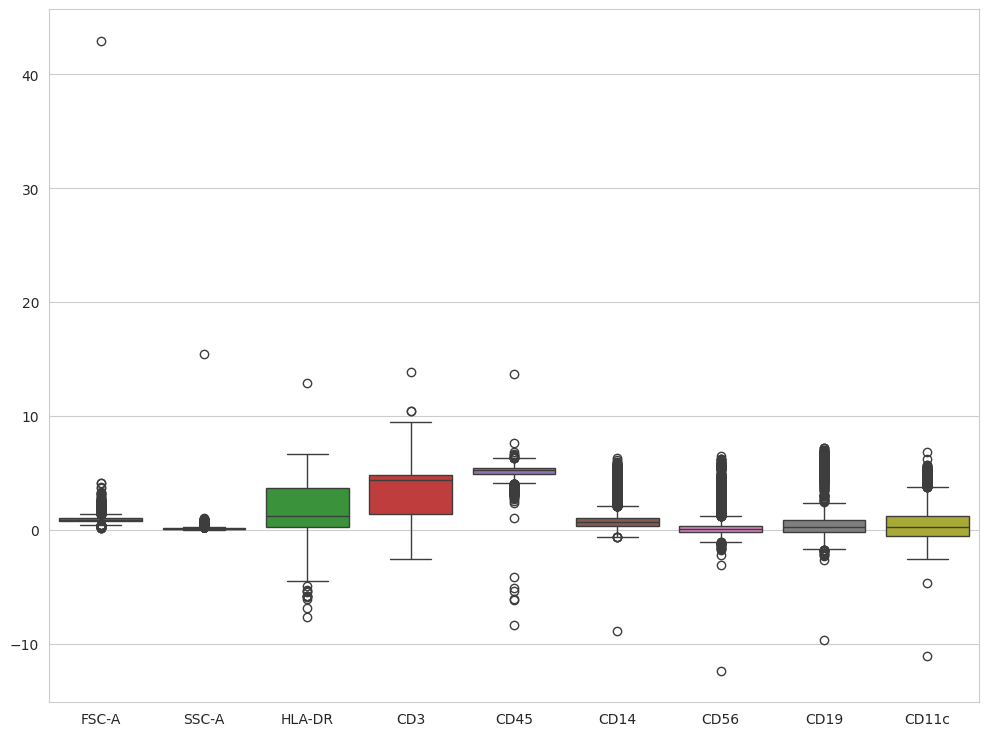

In [23]:
sns.boxplot(fc_data)

array([[<Axes: title={'center': 'FSC-A'}>,
        <Axes: title={'center': 'SSC-A'}>,
        <Axes: title={'center': 'HLA-DR'}>],
       [<Axes: title={'center': 'CD3'}>,
        <Axes: title={'center': 'CD45'}>,
        <Axes: title={'center': 'CD14'}>],
       [<Axes: title={'center': 'CD56'}>,
        <Axes: title={'center': 'CD19'}>,
        <Axes: title={'center': 'CD11c'}>]], dtype=object)

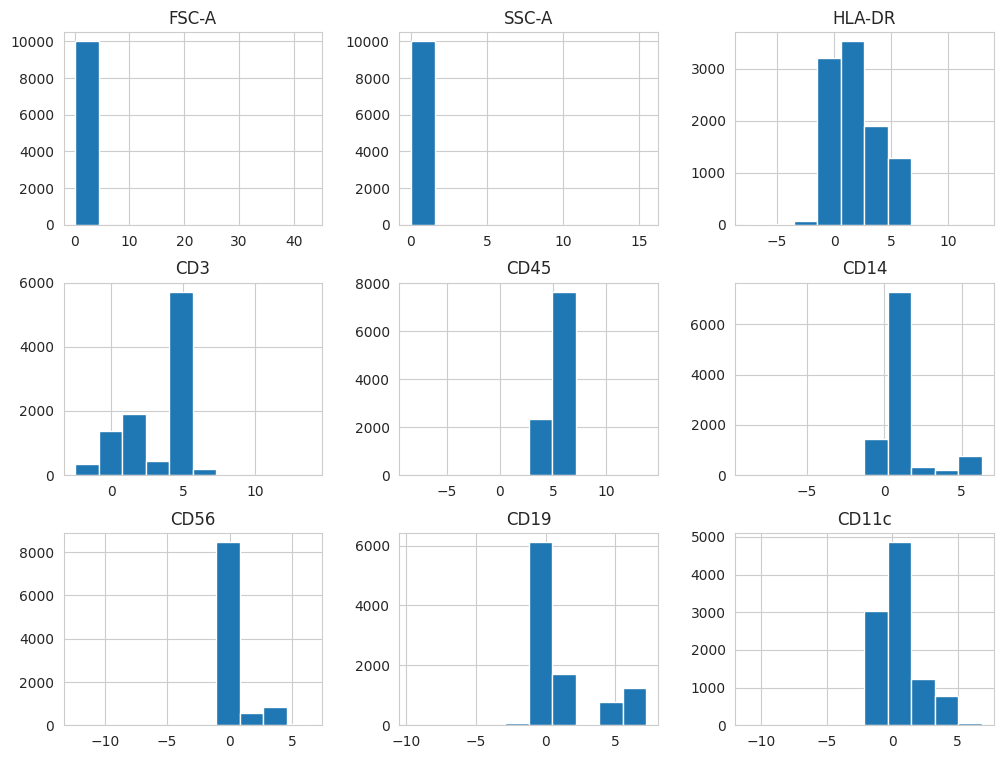

In [24]:
fc_data.hist()

В данных мы видим 9 флуоресцентных маркеров для проточки, маркер СD3 есть у т лимфоцитов; 45 - у многих клеток иммунной системы; CD14 - моноцитов и макрофагов, CD19 - B лимфоцитов,  CD56 — у NK клеток; CD18 и CD11c — у нейтрофилов; HLA-DR — антигенпредставляющих клеток иммунной системы; SSC-A и FSC-A — у всех типов клеток для анализа их размера и сложности. Соответственно, маркеры перекрываются, но можно выделить как минимум 6 кластеров. Присутствует действительно большой разброс значений, причем серьезный(max FSC-A 42, а CD11c - 6, при этом их средние значения ближе к 1). Однозначно стоит стандартизировать значения + по боксплоту мы видим, что у нас есть небольшое количество outlier'ов во всех колонках. Давайте их уберем и посмотрим на изменения в t-SNE

<Axes: >

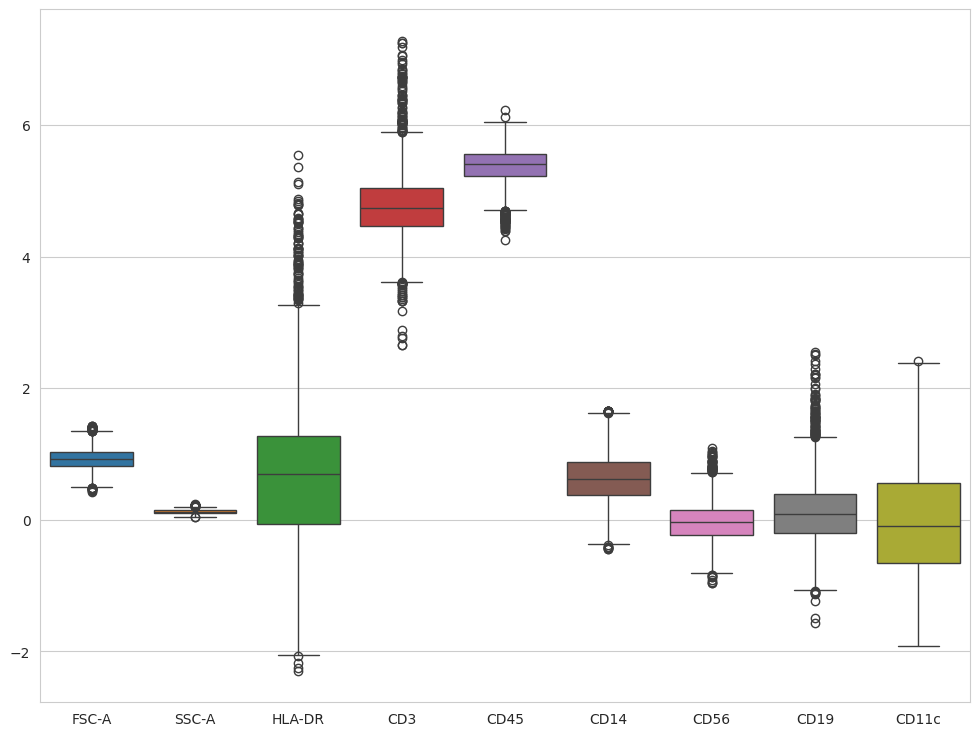

In [25]:
fc_data_out = fc_data
for col in fc_data_out.columns:
    Q1 = fc_data_out[col].quantile(0.25)
    Q3 = fc_data_out[col].quantile(0.75)
    IQR = Q3 - Q1

    # identify outliers
    threshold = 1.5
    outliers = fc_data_out[(fc_data_out[col] < Q1 - threshold * IQR) | (fc_data_out[col] > Q3 + threshold * IQR)]
    fc_data_out = fc_data_out.drop(outliers.index)
sns.boxplot(fc_data_out)

Стало лучше, однако объем данных уменьшился почти в половину(5399 образцов). Давайте в конце сравним, как это отразилось на кластеризации.

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [26]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

In [27]:
scaler = StandardScaler()
fc_data_st = normalize(scaler.fit_transform(fc_data))
fc_data_out_st = normalize(scaler.fit_transform(fc_data_out))

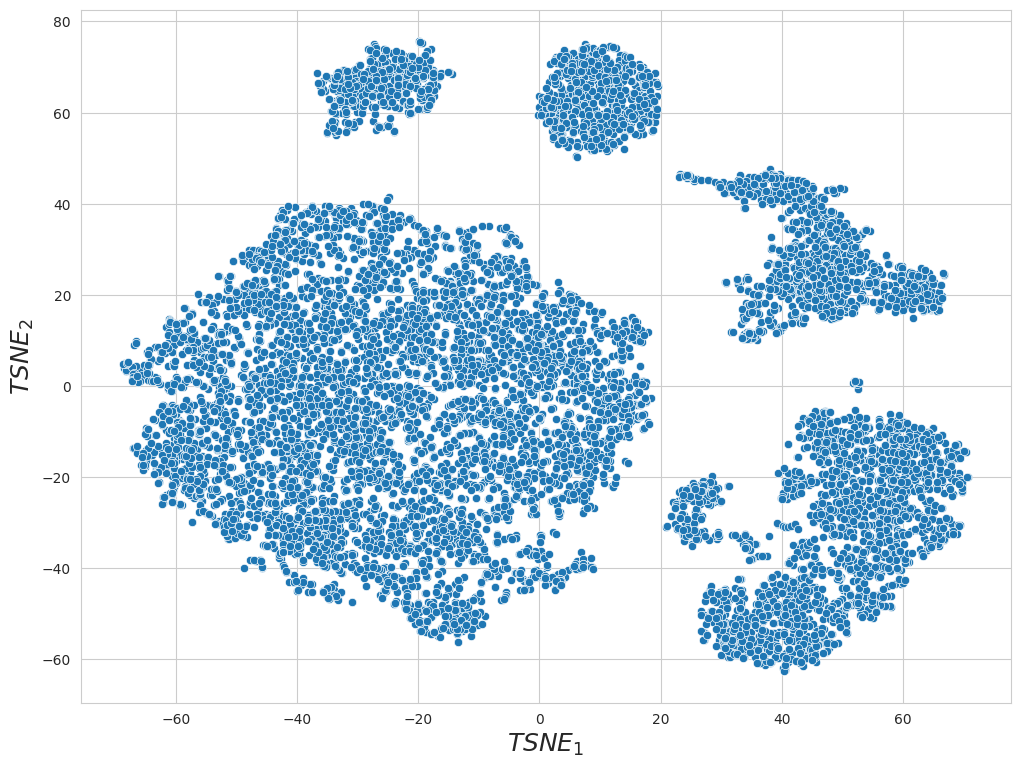

In [28]:
tsne_res = plot_tsne(fc_data_st)

Как мы видим, возможных кластеров действительно 5-7 штук

array([[  6.87882122, -19.87216078],
       [ 16.938612  , -30.18015299],
       [ 43.96167405, -27.57689512],
       ...,
       [ 21.97497061, -42.15488143],
       [-10.43698545,  39.65391681],
       [ 34.61520074, -15.27351348]])

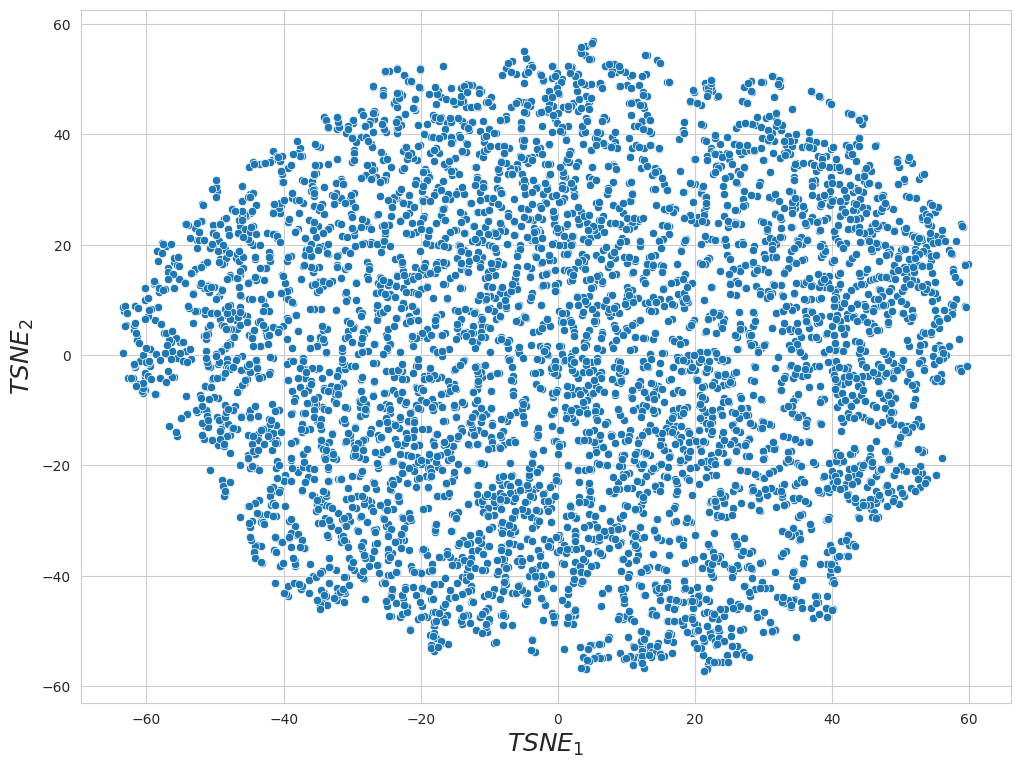

In [29]:
plot_tsne(fc_data_out_st)

Как мы идим, при выбросе аутлаеров у нас взможные кластеры схлопываются, это значит, что они отобраают важные признаки кластеров. Разумней было бы их оставить.

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

Попробуем с помощью agglemerative кластеризации. Сначала выберем метрики

In [30]:
algorithm_selection(fc_data_st, clusters=3).sort_values('silhouette') # попытался проверить наличие хотя бы 3 вырженных групп(лимфоциты, моноциты, гранулоциты) -> получается вроде

distance algorithm homogeneity completeness v_measure  silhouette
4   manhattan    single        None         None      None   -0.086751
1   euclidean    single        None         None      None   -0.070090
7   minkowski    single        None         None      None   -0.070090
10     cosine    single        None         None      None   -0.070090
5   manhattan  complete        None         None      None    0.269358
9      cosine   average        None         None      None    0.395589
0   euclidean   average        None         None      None    0.396101
6   minkowski   average        None         None      None    0.396101
2   euclidean  complete        None         None      None    0.396449
8   minkowski  complete        None         None      None    0.396449
11     cosine  complete        None         None      None    0.396449
3   manhattan   average        None         None      None    0.411879

In [31]:
algorithm_selection(fc_data_st, clusters=4).sort_values('silhouette')

distance algorithm homogeneity completeness v_measure  silhouette
1   euclidean    single        None         None      None   -0.173774
7   minkowski    single        None         None      None   -0.173774
10     cosine    single        None         None      None   -0.173774
4   manhattan    single        None         None      None   -0.119106
5   manhattan  complete        None         None      None    0.339721
9      cosine   average        None         None      None    0.447552
3   manhattan   average        None         None      None    0.450375
2   euclidean  complete        None         None      None    0.450675
8   minkowski  complete        None         None      None    0.450675
11     cosine  complete        None         None      None    0.450675
0   euclidean   average        None         None      None    0.452136
6   minkowski   average        None         None      None    0.452136

In [32]:
algorithm_selection(fc_data_st, clusters=5).sort_values('silhouette') # показания для 5 кластеров больше, чем для 6,7

distance algorithm homogeneity completeness v_measure  silhouette
1   euclidean    single        None         None      None   -0.184997
7   minkowski    single        None         None      None   -0.184997
10     cosine    single        None         None      None   -0.184997
4   manhattan    single        None         None      None   -0.143138
5   manhattan  complete        None         None      None    0.175192
2   euclidean  complete        None         None      None    0.328942
8   minkowski  complete        None         None      None    0.328942
11     cosine  complete        None         None      None    0.328942
3   manhattan   average        None         None      None    0.402396
0   euclidean   average        None         None      None    0.409190
6   minkowski   average        None         None      None    0.409190
9      cosine   average        None         None      None    0.429054

In [33]:
algorithm_selection(fc_data_st, clusters=6).sort_values('silhouette') # показания для 5 кластеров больше, чем для 6,7

distance algorithm homogeneity completeness v_measure  silhouette
1   euclidean    single        None         None      None   -0.197587
7   minkowski    single        None         None      None   -0.197587
10     cosine    single        None         None      None   -0.197587
4   manhattan    single        None         None      None   -0.146577
5   manhattan  complete        None         None      None    0.156701
2   euclidean  complete        None         None      None    0.318940
8   minkowski  complete        None         None      None    0.318940
11     cosine  complete        None         None      None    0.318940
3   manhattan   average        None         None      None    0.328260
9      cosine   average        None         None      None    0.355992
0   euclidean   average        None         None      None    0.383697
6   minkowski   average        None         None      None    0.383697

In [34]:
algorithm_selection(fc_data_st, clusters=7).sort_values('silhouette') # показания для 5 кластеров больше, чем для 6,7

distance algorithm homogeneity completeness v_measure  silhouette
1   euclidean    single        None         None      None   -0.200512
7   minkowski    single        None         None      None   -0.200512
10     cosine    single        None         None      None   -0.200512
4   manhattan    single        None         None      None   -0.184557
5   manhattan  complete        None         None      None    0.147769
2   euclidean  complete        None         None      None    0.243157
8   minkowski  complete        None         None      None    0.243157
11     cosine  complete        None         None      None    0.243157
3   manhattan   average        None         None      None    0.312302
9      cosine   average        None         None      None    0.328360
0   euclidean   average        None         None      None    0.348862
6   minkowski   average        None         None      None    0.348862

Лучшее комбо - manhattan(так как не убирали выбросы) + single(по данным силуэта), давайте так и сделаем.

Для того, чтобы точки адекватно кластеризовывались, нам нужно предобработать данные на tSNE

In [35]:
cluster = AgglomerativeClustering(n_clusters=5, linkage='single', metric='manhattan')
cluster_labels_agg = cluster.fit_predict(fc_data_st)

array([[  6.54218737,  52.47032928],
       [ 53.38029539, -38.10179599],
       [-36.67144159,  -6.13409589],
       ...,
       [ 31.57563231,  43.69952449],
       [  1.51533097,  58.14784001],
       [  9.73369265,  59.45761542]])

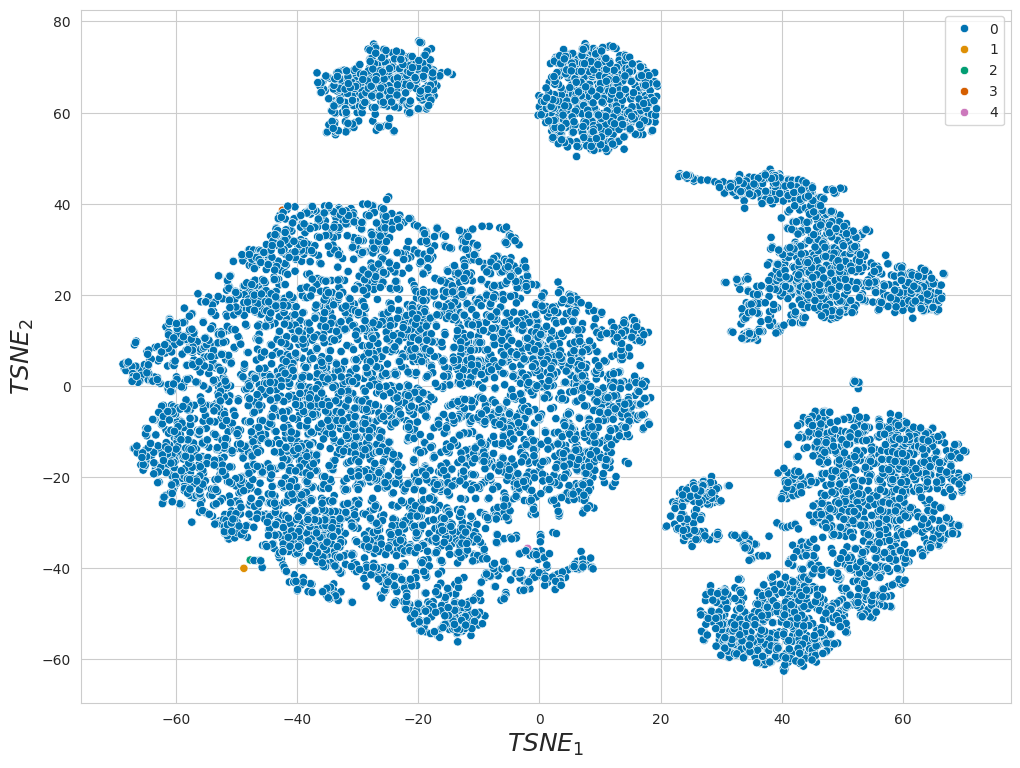

In [36]:
plot_tsne(fc_data_st, color=cluster_labels_agg)

Как мы видим, целостность кластера высокая, потому что ВСЕ ЭТО БОЛЬШОЙ КЛАСТЕР. Меняем параметры: сделаем евклидово расстояние(в нашем случае много выбросов было, возможно, манхэттан слишком к нему нечувствителен) + сделаем complete linkage (чтобы попытаться разбить кластер на более мелкие)

array([[  6.5784614 ,  52.36314818],
       [ 53.41501377, -38.07702097],
       [-36.65065829,  -6.13057064],
       ...,
       [ 31.64657903,  43.78158274],
       [  1.49633934,  58.04862716],
       [  9.75329524,  59.35859407]])

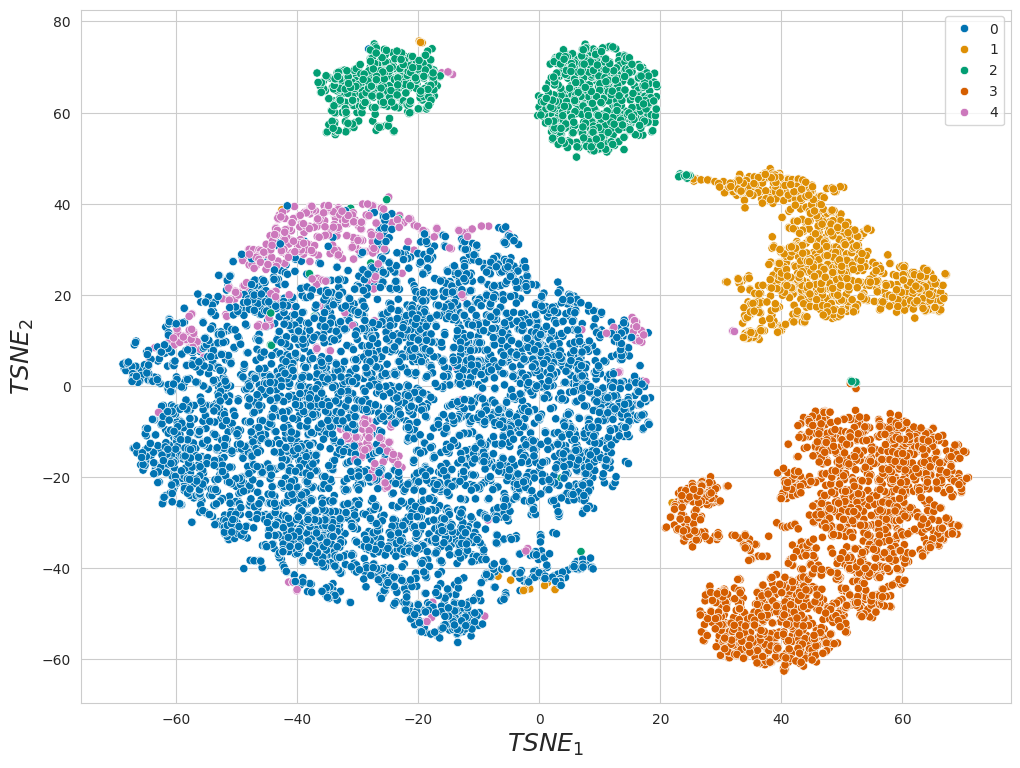

In [37]:
cluster = AgglomerativeClustering(n_clusters=5, linkage='complete', metric='euclidean')
cluster_labels_agg = cluster.fit_predict(fc_data_st)
plot_tsne(fc_data_st, color=cluster_labels_agg)

Уже лучше, однако теперь кажется лишним класс 4 - возможно он одно целое с классом 0. Давайте попробуем нарисовать тсне для 4 кластеров и посмотрим какой исчезнет

array([[  6.5784614 ,  52.36314818],
       [ 53.41501377, -38.07702097],
       [-36.65065829,  -6.13057064],
       ...,
       [ 31.64657903,  43.78158274],
       [  1.49633934,  58.04862716],
       [  9.75329524,  59.35859407]])

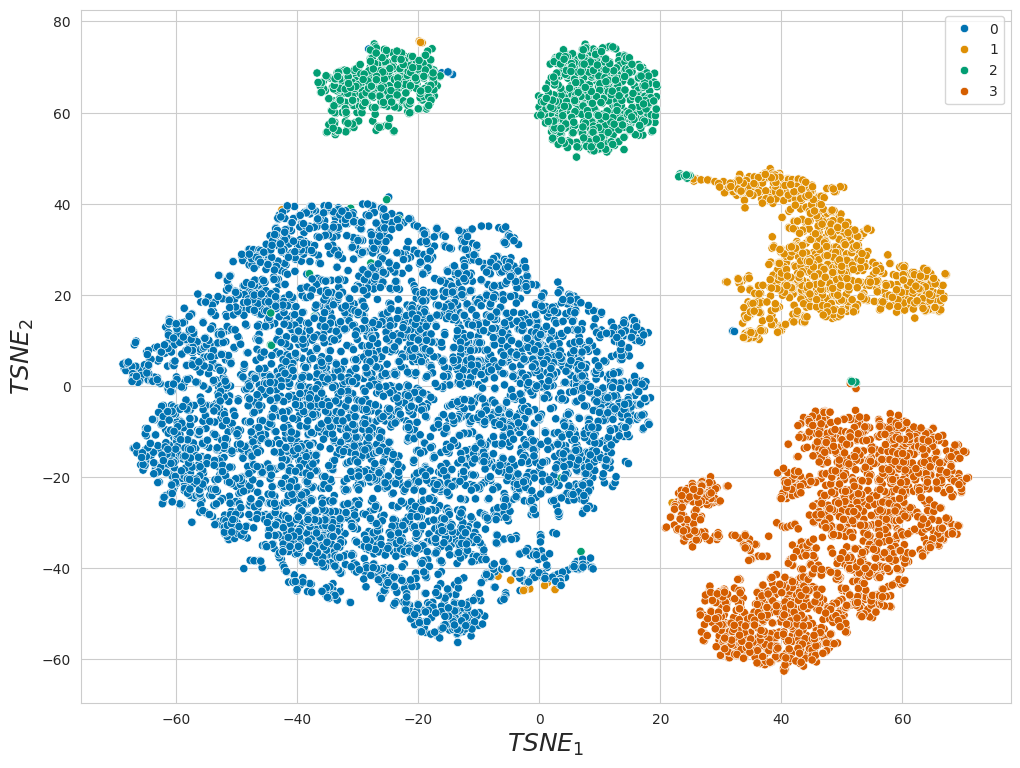

In [38]:
cluster = AgglomerativeClustering(n_clusters=4, linkage='complete', metric='euclidean')
cluster_labels_agg = cluster.fit_predict(fc_data_st)
plot_tsne(fc_data_st, color=cluster_labels_agg)

4 класс исчез

Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет? Да

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

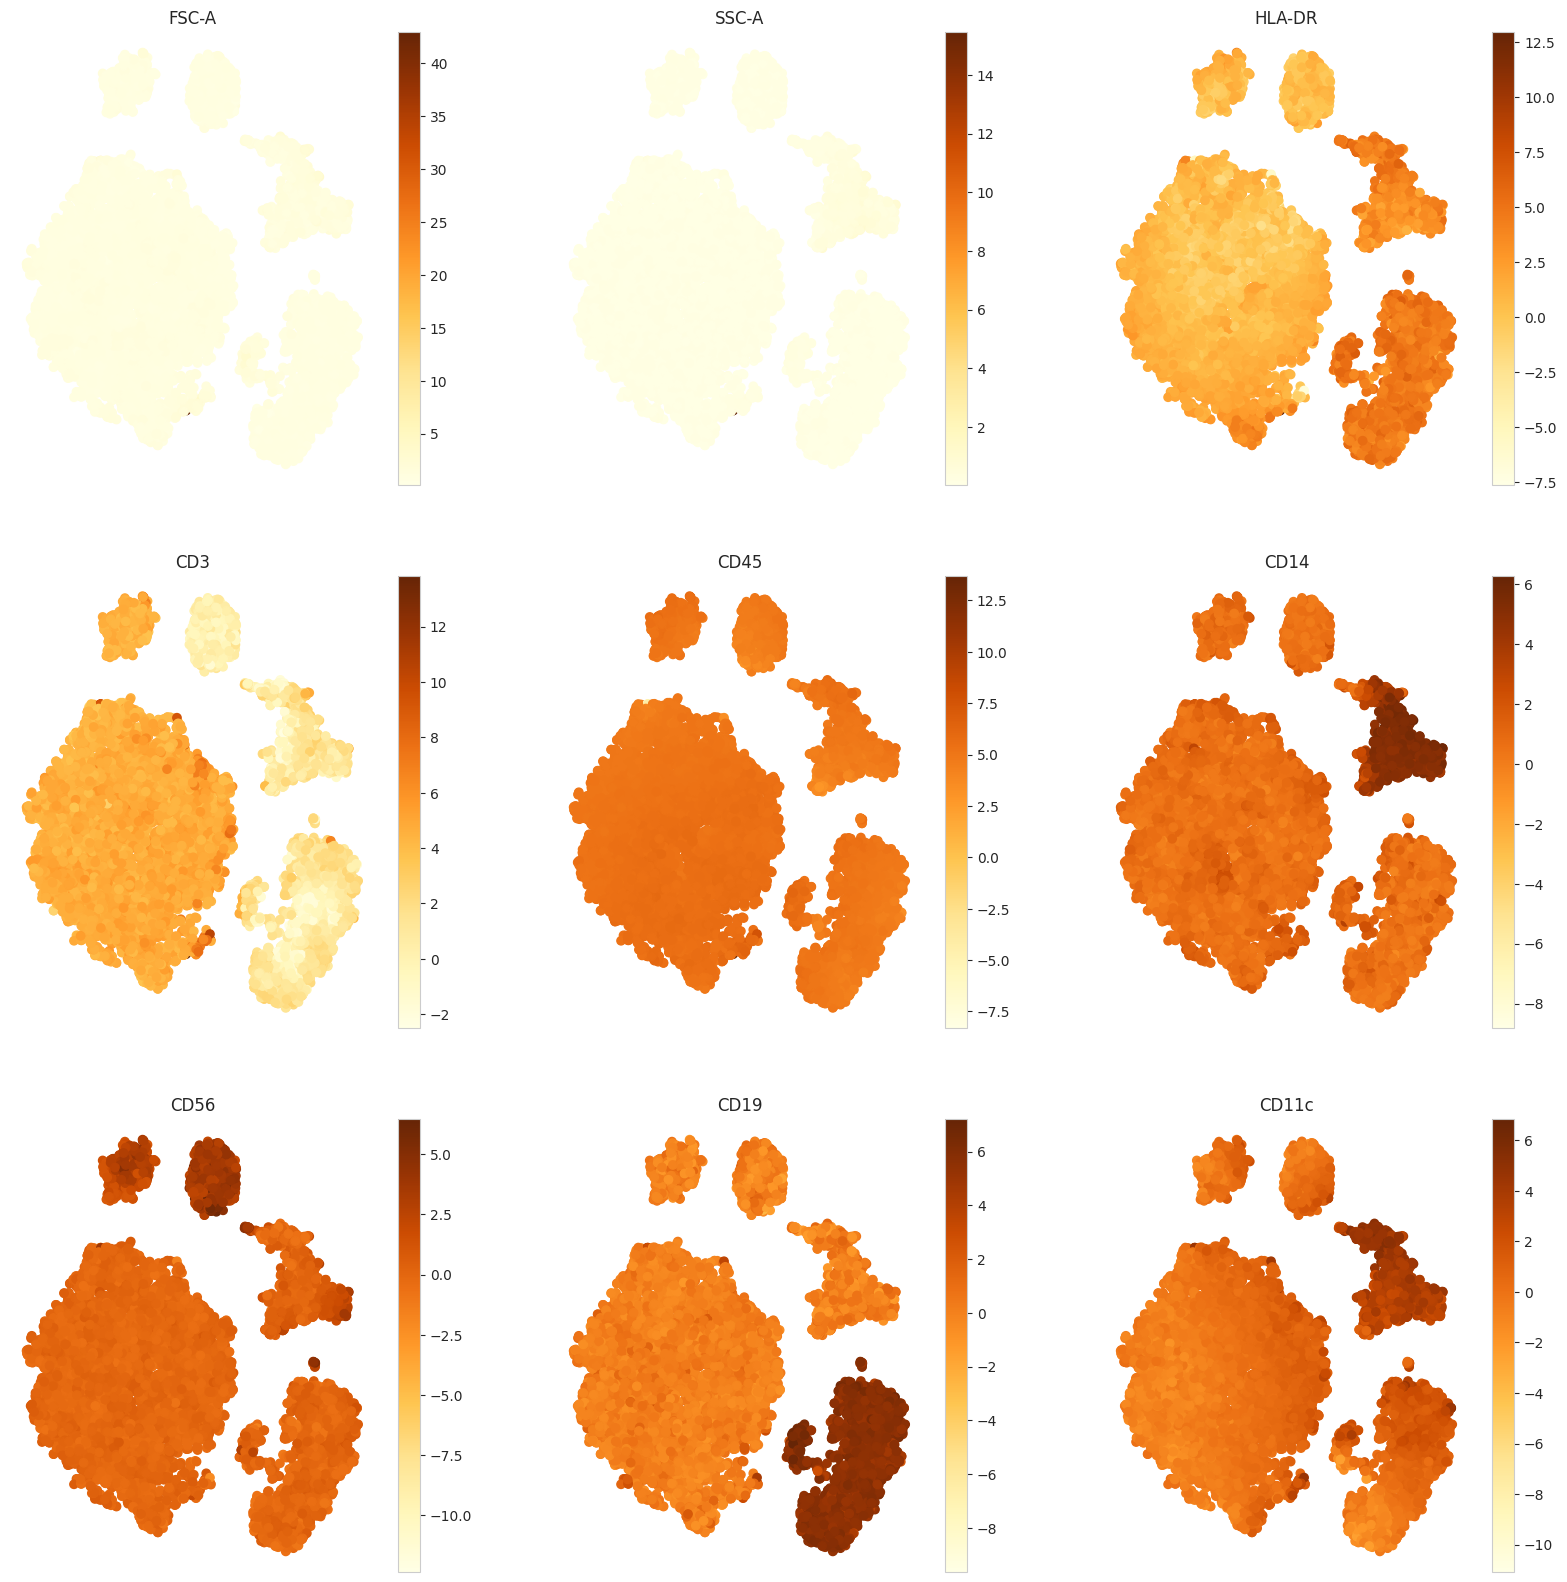

In [39]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

In [40]:
cell_type_cluster_map = {0: "T_cells", # определение T клеток, о которых говорилось в задании, слишком неоднозначно (CD3+ есть в 0 и 2 кластере, при этом там нормально так присутствует CD19+. Так что сказать, что есть "чистые" t клетки нельзя)
                         1: "Monocytes", # CD14+CD3- однозначный маркер моноцитов 
                         2: "Other cells", # 2 популяции с CD56+, скорее всего NK-клетки (CD3-) и T-NK клетки(CD3+) 
                         3: "B_cells"} # CD19+СD3- однозначный маркер b клеток

In [41]:
labeled_fc_data = fc_data.assign(Population=cluster_labels_agg)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

Посчитайте, как распределены типы клеток:

In [42]:
labeled_fc_data.groupby('Population').count().reset_index()

Population  FSC-A  SSC-A  HLA-DR   CD3  CD45  CD14  CD56  CD19  CD11c
0      B_cells   2026   2026    2026  2026  2026  2026  2026  2026   2026
1    Monocytes   1103   1103    1103  1103  1103  1103  1103  1103   1103
2  Other cells   1129   1129    1129  1129  1129  1129  1129  1129   1129
3      T_cells   5742   5742    5742  5742  5742  5742  5742  5742   5742

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [43]:
labeled_fc_data.to_csv('../data/labeled_fc_data.csv')

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**